# NLP Challenge

Objective: Determine if a given text was translated by a machine or a professional translator.

For this project I was given a dataset with translated texts. The texts were translated by either a machine or a human, and we must determine which is which. The dataset contains two columns: the label and the translated text. The label is either 0 or 1, where 0 means the text was translated by a machine and 1 means the text was translated by a human **(0 = Machine, 1 = Human)**.

## Data Exploration

We start by loading the data and checking the first few rows. The data is simply a txt file with the label and the text separated by a tab. After loading the data, we added column names for easier access and change the label type to integer.

From the data info, we can see that there are no missing values, and has a total of ~15,000 entries. I also printed the first 5 texts to get a sense of the data. The `df.head()` did not print the full text, so I printed the first 5 texts individually.

In [1]:
# Load dataset from txt file
import numpy as np
import pandas as pd


df = pd.read_csv('./data/TRAINING_DATA.txt', sep = '\t', header = None)
df.columns = ['label', 'text']
df['label'] = df['label'].astype('category')
df['label'] = df['label'].cat.codes

display(df.info())
display(df.head(5))

print("""********************************************

Printing first 5 texts, since df.head() does not display the full text
""")
print(df.values[:5,1])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14924 entries, 0 to 14923
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   14924 non-null  int8  
 1   text    14924 non-null  object
dtypes: int8(1), object(1)
memory usage: 131.3+ KB


None

,label,text
0,1,"Cuando conocí a Janice en 2013 , una familia n..."
1,0,Hwang habló en Sur de este año por Southwest M...
2,1,Usted podría pensar Katy Perry y Robert Pattin...
3,1,Cualquiera que haya volado los cielos del crea...
4,1,"Bueno , este cantante tendrá un LARGO tiempo p..."


********************************************

Printing first 5 texts, since df.head() does not display the full text

['Cuando conocí a Janice en 2013 , una familia necesitaba 600 puntos , en promedio , para ser asignada a un apartamento del ayuntamiento de Camden .'
 'Hwang habló en Sur de este año por Southwest Music and Media Conference sobre el tema de " videos caseros-lanzallamas " en YouTube .'
 'Usted podría pensar Katy Perry y Robert Pattinson reencontrándose en Coachella es una gran noticia , ¡ hasta que es coronado por quién se toparon !'
 'Cualquiera que haya volado los cielos del creador ha escuchado todo el acto del prevuelo con la información de seguridad hasta ahora , pero esta empleada ha volteado el guión un poco !'
 'Bueno , este cantante tendrá un LARGO tiempo para sentir aún más remordimiento en estos próximos años !']


Now we will do a simple visualization to see the distribution of the labels. We can see that the dataset is balanced, with ~50% of the texts translated by a machine and ~50% by a human.

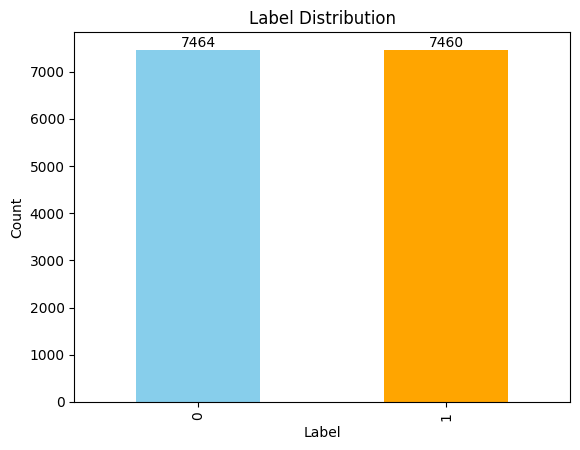

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# plot label distribution
df.label.value_counts().plot(kind='bar', color = ['skyblue', 'orange'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution')

# add count above the bar
for i in range(len(df.label.value_counts())):
    plt.text(i, df.label.value_counts()[i], df.label.value_counts()[i], ha = 'center', va = 'bottom')

plt.show()

## Data Preprocessing

To continue with the data preprocessing, we will simply check that there are no tags (like html, css, or other encodings) in the text. Characters like commas and periods will not be removed, and the text will not be changed to lowercase, as it may affect the model's performance. We will use a function in `nlp_utils.py` to remove any tags from the text.

Here is the code to remove tags from the text:

>    ```python
>    import re
>    from bs4 import BeautifulSoup
>    def clean_text(text):
>        text = re.sub(r'<(script|style).*?>.*?</\1>', '', text, flags=re.DOTALL)    # Step 1: Remove inline JavaScript/CSS
>
>        text = re.sub(r'<!--.*?-->', '', text, flags=re.DOTALL)  # Step 2: Remove HTML comments
>
>        soup = BeautifulSoup(text, 'html.parser')   # Step 3: Remove remaining HTML tags using BeautifulSoup
>        text = soup.get_text(separator=' ')  # Extract text and separate with spaces
>        
>        text = re.sub(r'=[0-9A-Fa-f]{2}', ' ', text)     # Step 4: General regex to remove any encodings like =XX (two hexadecimal digits)
>
>        text = re.sub(r'\s+', ' ', text).strip()        # Step 5: Remove extra whitespace
>
>        text = text.lstrip('b')     # Remove prefixed 'b'
>        
>        text = re.sub(r'\s+', ' ', text) # Remove any extra spaces again, just to be sure
>
>        return text
>    ```

In [3]:
from nlp_utils import clean_text

# clean text
df['cleaned_text'] = df['text'].apply(clean_text)
df.head(5)

/content/nlp_utils.py:14: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


,label,text,cleaned_text
0,1,"Cuando conocí a Janice en 2013 , una familia n...","Cuando conocí a Janice en 2013 , una familia n..."
1,0,Hwang habló en Sur de este año por Southwest M...,Hwang habló en Sur de este año por Southwest M...
2,1,Usted podría pensar Katy Perry y Robert Pattin...,Usted podría pensar Katy Perry y Robert Pattin...
3,1,Cualquiera que haya volado los cielos del crea...,Cualquiera que haya volado los cielos del crea...
4,1,"Bueno , este cantante tendrá un LARGO tiempo p...","Bueno , este cantante tendrá un LARGO tiempo p..."


## Model Building

Since we need to classify text snippets into two classes, we will use a text classification model. I decided to implement a **BERT** model, as it is a powerful model for NLP tasks. We will use the `transformers` library to load a pre-trained BERT model and tokenizer. We will use the `BertForSequenceClassification` model, which is a BERT model with a classification head on top. We will also use the `BertTokenizer` to tokenize the text. Finally, the actual reason why I chose BERT was to get some insights into how it works and how it can be used for text classification tasks.

For the task of determining whether a translation was done by a machine or a human, using BERT would indeed be a good choice. Here's why:

### Why BERT for This Task?
1. **Contextual Understanding**: BERT's bidirectional nature allows it to capture subtle differences in language, such as fluency, grammar, and structure, which can often distinguish human translations from machine translations.
2. **Fine-tuning Capabilities**: You can fine-tune a pre-trained BERT model on your dataset with labeled examples of human and machine translations, allowing it to learn the specific patterns that characterize each.
3. **Handling Long Texts**: Translations might have complex sentence structures or nuanced phrasing. BERT can effectively handle these complexities due to its ability to consider both left and right contexts.

First, we import the necessary libraries, or install them and import them if they are not already installed. We will also set the device to GPU if available. We will then load the pre-trained BERT model and tokenizer. We will use the `XLM RoBERTa` model, since the text inputs are in Spanish, and XLM RoBERTa is a multilingual model that can handle multiple languages. We will also use the `BertTokenizer` to tokenize the text.

In [4]:
try:
    import transformers
    print(f"transformers version: {transformers.__version__}")
except ImportError:
    %pip install transformers
    import transformers

try:
    import torch
    print(f"torch version: {torch.__version__}")
except ImportError:
    %pip install torch
    import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(torch.cuda.get_device_name())

transformers version: 4.47.1
torch version: 2.5.1+cu124
Tesla T4


Now that we downloaded some necessary libraries, we can proceed with the model building. First, we will split the data into training and validation sets (80:20).

In [5]:
# split data
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df[['cleaned_text', 'label']], test_size=0.2, random_state=42)
X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=42)
X_train.shape, X_val.shape, X_test.shape

((9551, 2), (2388, 2), (2985, 2))

Now that the dataset is divided into the testing and training set, we will tokenize the text using the `BertTokenizer`. We will also create a DataLoader for the training and validation sets. We will use a batch size of 16 for both the training and validation sets.

Here we defined the model we will use, xlm roberta base, and tokenized the text. Finally we loaded the pretrained model.

In [ ]:
# from torch.utils.data import Dataset

# # Create a custom Dataset class to return a dict for each batch
# class CustomDataset(Dataset):
#     def __init__(self, input_ids, attention_mask, labels):
#         self.input_ids = input_ids
#         self.attention_mask = attention_mask
#         self.labels = labels

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, idx):
#         return {
#             'input_ids': self.input_ids[idx],
#             'attention_mask': self.attention_mask[idx],
#             'labels': self.labels[idx]
#         }



In [6]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import TensorDataset
from nlp_utils import CustomDataset

# model name
model_name = "distilbert-base-multilingual-cased"

# Load pre-trained multilingual BERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

# Tokenize the dataset (same steps as before)
def tokenize_function(text):
    return tokenizer(text, padding='max_length', truncation=True, max_length=200)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [7]:
# Apply the tokenization function to the 'cleaned_text' column
X_train['input_ids'] = X_train['cleaned_text'].apply(lambda x: tokenize_function(x)['input_ids'])
X_train['attention_mask'] = X_train['cleaned_text'].apply(lambda x: tokenize_function(x)['attention_mask'])

# Do the same for the test set
X_val['input_ids'] = X_val['cleaned_text'].apply(lambda x: tokenize_function(x)['input_ids'])
X_val['attention_mask'] = X_val['cleaned_text'].apply(lambda x: tokenize_function(x)['attention_mask'])



# Convert the columns to PyTorch tensors
train_input_ids = torch.tensor(X_train['input_ids'].tolist())
train_attention_mask = torch.tensor(X_train['attention_mask'].tolist())
train_labels = torch.tensor(X_train['label'].tolist())

val_input_ids = torch.tensor(X_val['input_ids'].tolist())
val_attention_mask = torch.tensor(X_val['attention_mask'].tolist())
val_labels = torch.tensor(X_val['label'].tolist())


# Create datasets using the custom class
train_dataset = CustomDataset(train_input_ids, train_attention_mask, train_labels)
val_dataset = CustomDataset(val_input_ids, val_attention_mask, val_labels)


In [8]:
# Load the pre-trained multilingual BERT model with a classification head
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Below we made a function for the metrics, as well as training arguments and the trainer. We will train the model using the `Trainer` class from the `transformers` library. We will use the `Trainer` class to train the model on the training set and evaluate it on the validation set. We will use the `Accuracy` metric to evaluate the model's performance.

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {'accuracy': accuracy_score(labels, predictions),
            'precision': precision_score(labels, predictions),
            'recall': recall_score(labels, predictions),
            'f1': f1_score(labels, predictions)
            }

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    learning_rate=2e-5,  # Explicitly set a lower learning rate
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,  # Add evaluation batch size
    evaluation_strategy="epoch",    # Enable evaluation after each epoch
    report_to="none"                # Disable W&B logging
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.835654,0.526382,0.521951,0.541772,0.531677
2,0.140600,2.129892,0.520938,0.514866,0.599156,0.553822
3,0.140600,2.257175,0.522613,0.515485,0.632068,0.567854
4,0.069800,2.965220,0.528057,0.522137,0.577215,0.548297
5,0.069800,3.135332,0.520101,0.513742,0.615190,0.559908
6,0.038800,2.646590,0.523869,0.517910,0.585654,0.549703
7,0.078400,2.921617,0.522613,0.516532,0.593249,0.552239
8,0.078400,2.906550,0.525126,0.519216,0.581435,0.548567
9,0.056600,3.236785,0.520938,0.514426,0.616878,0.561013
10,0.056600,3.250774,0.522613,0.516293,0.601688,0.555729


TrainOutput(global_step=2990, training_loss=0.07212228296592482, metrics={'train_runtime': 1783.342, 'train_samples_per_second': 53.557, 'train_steps_per_second': 1.677, 'total_flos': 4942172361576000.0, 'train_loss': 0.07212228296592482, 'epoch': 10.0})

Now we tokenize the test set too, and make predictions on the test set and calculated the accuracy of the model.

In [11]:
# Do the same for the test set
X_test['input_ids'] = X_test['cleaned_text'].apply(lambda x: tokenize_function(x)['input_ids'])
X_test['attention_mask'] = X_test['cleaned_text'].apply(lambda x: tokenize_function(x)['attention_mask'])

test_input_ids = torch.tensor(X_test['input_ids'].tolist())
test_attention_mask = torch.tensor(X_test['attention_mask'].tolist())
test_labels = torch.tensor(X_test['label'].tolist())

test_dataset = CustomDataset(test_input_ids, test_attention_mask, test_labels)


predictions = trainer.predict(test_dataset)

accuracy = compute_metrics((predictions.predictions, predictions.label_ids))['accuracy']
print(f'Accuracy on test set: {accuracy}')


Accuracy on test set: 0.49715242881072025


Now we save the model and tokenizer to disk.

In [13]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define Google Drive folder path
drive_folder_path = '/content/drive/My Drive/Colab Notebooks/animals10 CNN Project/distilbert'

# Save the model
model.save_pretrained(drive_folder_path)
tokenizer.save_pretrained(drive_folder_path)
trainer.save_model(drive_folder_path)


Mounted at /content/drive


Finally, we make a confusion matrix to see the model's performance.

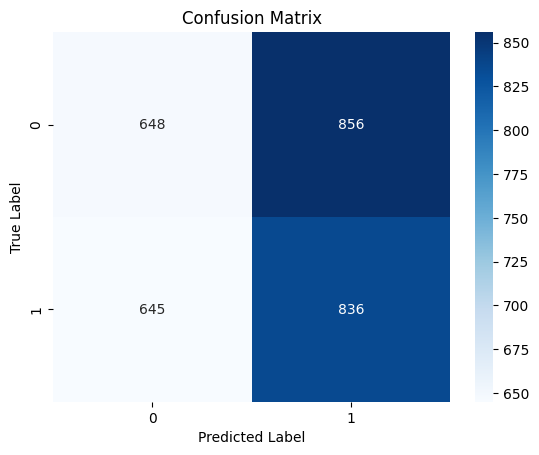

In [12]:
# confusion matrix
from sklearn.metrics import confusion_matrix

# Extract logits (the raw outputs from the model)
logits = predictions[0]

# Convert logits to predicted class (0 or 1) using argmax
predicted_classes = np.argmax(logits, axis=-1)


confusion_matrix(X_test['label'], predicted_classes)

# plot confusion matrix
sns.heatmap(confusion_matrix(X_test['label'], predicted_classes), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# save predictions
pred_label = pd.DataFrame({'label': predicted_classes})
pred_label.to_csv('./data/predictions.csv', index=False)

